In [1]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as scipystats
from matplotlib.pyplot import figure

from analysis.processing.epochs import get_epochs
from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
source = '/home/andrey/storage2/andrey/data/processed'
ex_animal = '00908'
ex_session = '2019-07-08_17-46-20'

sessionpath = os.path.join(source, ex_animal, ex_session)
h5file = os.path.join(sessionpath, 'all.h5')
with h5py.File(h5file, 'r') as f:
    traj = np.array(f['animal_trajectory'])
    idxs_A = np.array(f['A_idxs'])
    idxs_B = np.array(f['B_idxs'])
    
    print(len(traj), len(idxs_A), len(idxs_B))
    
    #print([(k, v) for k, v in f['arena_trajectory'].attrs.items()])
    print(list(f))

59269 15892 16771
['A_idxs', 'B_idxs', 'animal_trajectory', 'arena_trajectory', 'head_direction', 'metadata', 'running_idxs', 'units', 'velocity']


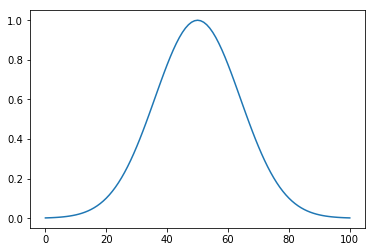

In [10]:
from scipy import signal
ker_width = 100
gs = signal.gaussian(ker_width + 1, std=(ker_width + 1) / 7.2)
plt.plot(gs)

In [4]:
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  # no '002784'

early_per = get_sessions_list(source, animals, 'SHIFT periodic')
early_per.remove(['00908', '2019-07-08_17-46-20', 'SHIFT periodic'])  # broken session
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')    # missing just BOTH!
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')  # 003281, 003282 - remove completely? wrong gain

## Probing trajectory stops

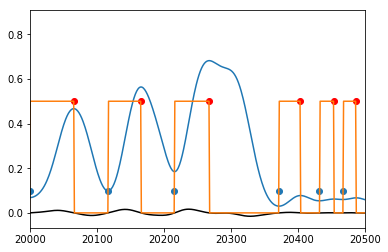

In [23]:
source = '/home/andrey/storage2/andrey/data/processed'
source = '/storage2/andrey/data/processed'

def get_tvps(sessionpath):
    h5file = os.path.join(sessionpath, 'all.h5')
    with h5py.File(h5file, 'r') as f:
        traj = np.array(f['animal_trajectory'])
        velocity = np.array(f['velocity'])
        A_idxs = np.array(f['A_idxs'])
        B_idxs = np.array(f['B_idxs'])
        #occ_map = np.array(f['units']['1_2']['A']['01_occupancy'])

    traj[:, 1] = -1 * traj[:, 1]
    data  = velocity[:, 1]
    grad  = np.gradient(data)
    zeros = np.where(np.diff(np.sign(grad)))[0]
    peaks = np.where(np.diff(np.sign(grad)) == -2)[0]
    stops = np.where(np.diff(np.sign(grad)) == 2)[0]
    peaks = np.array([peaks[np.where(peaks < stop)[0]][-1] for stop in stops])
    
    return traj, velocity, peaks, stops


ex_animal, ex_session = visual_s[4][0], visual_s[4][1]
sessionpath = os.path.join(source, ex_animal, ex_session)
traj, velocity, peaks, stops = get_tvps(sessionpath)

if True:
    plt.plot(data)  # velocity
    plt.plot(grad, color='black')  # gradient
    plt.plot(0.25*(np.sign(grad) + 1))  # square-like sign of gradient
    plt.scatter(peaks, 0.5*np.ones(len(peaks)), color='red')  # actual peaks
    plt.scatter(stops, 0.1*np.ones(len(stops)))  # sctual stops
    plt.xlim(20000, 20500)

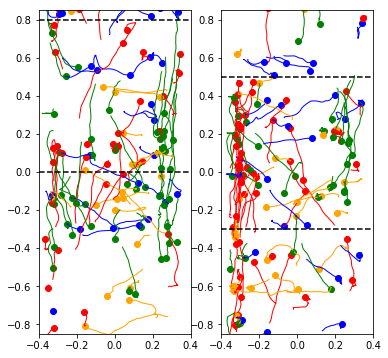

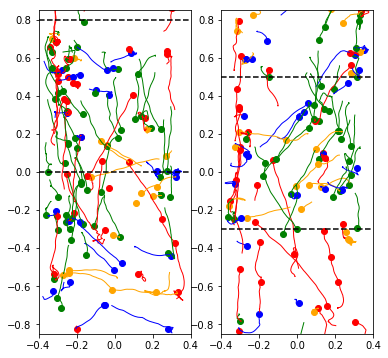

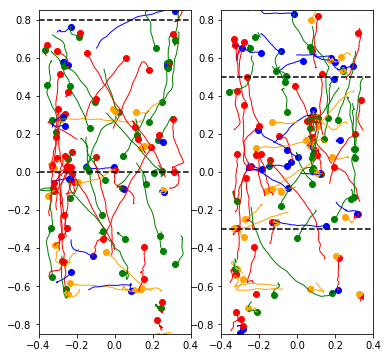

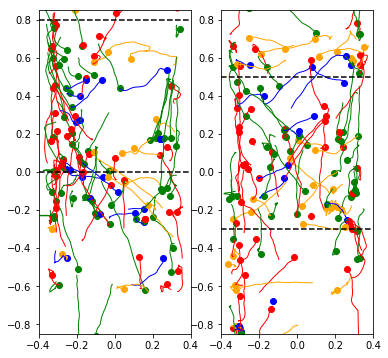

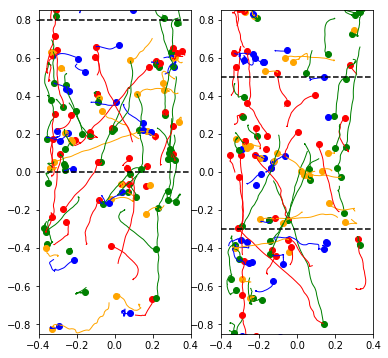

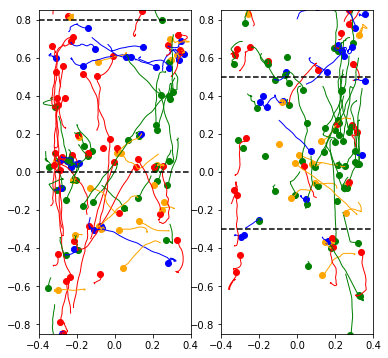

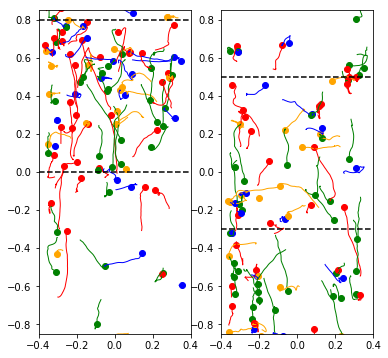

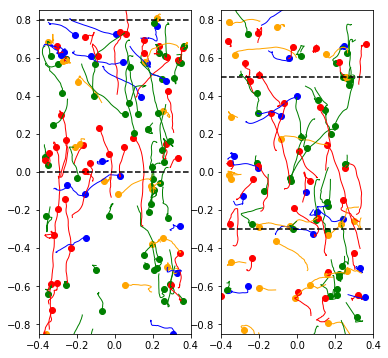

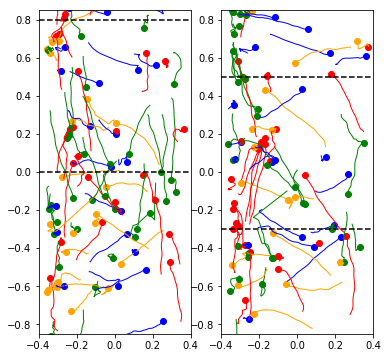

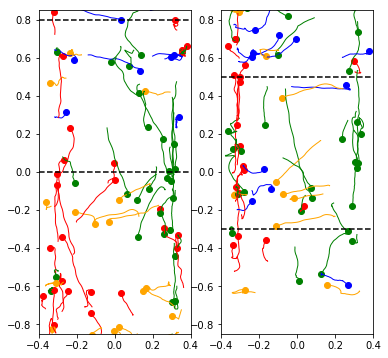

In [24]:
# if stops[0] < peaks[0]:
#     stops = stops[1:]
# if peaks[-1] > stops[-1]:
#     peaks = peaks[:-1]

animal = '003908'
sessions = [ss for ss in single + periodic if ss[0] == animal]

for session in sessions[:10]:
    sessionpath = os.path.join(source, session[0], session[1])
    traj, velocity, peaks, stops = get_tvps(sessionpath)
    
    all_poi_idxs = stops[np.where(traj[stops][:, 0] - traj[peaks][:, 0] > 0.5)[0]]  # stops only if animal ran > 0.5 sec 
    stop_poi_idxs = all_poi_idxs[np.where(velocity[:, 1][all_poi_idxs] < 0.1)[0]]   # and has also speed < 0.1 m/s
    speed_peak_idxs = peaks[np.where(velocity[:, 1][peaks] > 0.45)[0]]  # peaks where speed > 0.45 (very high)

    fig, ax = plt.subplots(1, 2)
    fig.set_figheight(8)
    colors = ['red', 'blue', 'green', 'orange']

    for i, idxs in enumerate([A_idxs, B_idxs]):
        factor = 0.15 if i == 0 else -0.15
        factor = 0
        res_idxs = np.intersect1d(idxs, stop_poi_idxs)

        for idx in res_idxs: # idxs of stops in particular condition (A, B, etc)
            #avg_by = 25
            #orientation = []
            #idx_left, idx_right = idx - 100, idx - avg_by  # 50 samples back, ~0.5 sec
            #for j, position in enumerate(traj[idx_left:idx_right]):
            #    vectors = [np.array([x[1], x[2]]) - np.array([position[1], position[2]]) for x in traj[idx_left + j + 1:idx_left + j + avg_by]]
            #    avg_direction = np.array(vectors).sum(axis=0) / len(vectors)
            #    avg_angle = np.arctan2(avg_direction[1], avg_direction[0])
            #    orientation.append(avg_angle)

            #bout_angle = scipystats.circmean(np.array(orientation))

            bout_angle = np.arctan2(traj[:, 1][idx] - traj[:, 1][idx-100], traj[:, 2][idx] - traj[:, 2][idx-100])
            bout_angle = np.degrees(bout_angle)
            bout_angle = (bout_angle + 45) % 360
            color = colors[int(np.floor(bout_angle / 90.0))]

            #if color == 'red' or color == 'green':
            ax[i].scatter(traj[:, 1][idx], traj[:, 2][idx] + factor, color=color)
            ax[i].plot(traj[:, 1][idx-100:idx], traj[:, 2][idx-100:idx] + factor, color=color, lw=1)

        #res_idxs = np.intersect1d(idxs, speed_peak_idxs)
        #ax[i].scatter(traj[:, 1][res_idxs], traj[:, 2][res_idxs] + factor, color='red', alpha=0.5)

        ax[i].set_ylim(-0.85, 0.85)
        ax[i].set_xlim(-0.4, 0.4)
        ax[i].set_aspect('equal')

        offset = 0 if i == 0 else -0.3
        ax[i].axhline(0.8 + offset, ls='--', color='black')
        ax[i].axhline(0 + offset, ls='--', color='black')


## Rearing

In [4]:
source = '/home/andrey/storage2/andrey/data/processed'
source = '/storage2/andrey/data/processed'
ex_animal, ex_session = visual_s[2][0], visual_s[2][1]

sessionpath = os.path.join(source, ex_animal, ex_session)
h5file = os.path.join(sessionpath, 'all.h5')
with h5py.File(h5file, 'r') as f:
    traj = np.array(f['animal_trajectory'])
    A_idxs = np.array(f['A_idxs'])
    B_idxs = np.array(f['B_idxs'])
    

fig, ax = plt.subplots(1, 2)
fig.set_figheight(8)

idxs = np.where(traj[:, 3] > 0.6)[0]
idxs_A = np.intersect1d(idxs, A_idxs)
idxs_B = np.intersect1d(idxs, B_idxs)
ax[0].scatter(traj[:, 1][idxs_A], traj[:, 2][idxs_A])
ax[1].scatter(traj[:, 1][idxs_B], traj[:, 2][idxs_B])


NameError: name 'visual_s' is not defined

### Patch epoch idxs

In [28]:
def is_in_periods(t, periods):
    for period in periods:
        if t > period[0] and t < period[1]:
            return True
    return False

selection = gain_14

for animal, session, exp_type in selection:
    session_path = os.path.join(source, animal, session)
    h5file = os.path.join(session_path, 'all.h5')
    epochs = get_epochs(session_path)
    
    with h5py.File(h5file, 'r+') as f:
        trajectory = np.array(f['animal_trajectory'])
        traj_times_norm = trajectory[:, 0] - trajectory[0][0]
        
        for name, periods in epochs.items():
            curr_idxs = []
            for i, t in enumerate(traj_times_norm):
                if is_in_periods(t, periods):
                    curr_idxs.append(i)
        
            epoch_idxs_name = '%s_idxs' % name
            if epoch_idxs_name in f.keys():
                del f[epoch_idxs_name]

            f.create_dataset(epoch_idxs_name, data=np.array(curr_idxs))
            f[epoch_idxs_name].attrs['description'] = "Trajectory indexes for condition %s" % name
    print('Processed: %s %s' % (animal, session))

Processed: 003281 2019-11-07_21-41-36
Processed: 003281 2019-11-17_15-34-04
Processed: 003281 2019-11-20_15-15-05
Processed: 003282 2019-11-07_22-05-39
Processed: 003282 2019-11-08_17-35-28
Processed: 003282 2019-11-11_13-04-49
Processed: 003282 2019-11-12_21-23-37
Processed: 003282 2019-11-12_20-24-17
Processed: 003282 2019-11-12_15-29-13
Processed: 003282 2019-11-13_12-54-37
Processed: 003282 2019-11-13_22-18-19
Processed: 003282 2019-11-14_20-47-14
Processed: 003282 2019-11-17_15-59-58
Processed: 003282 2019-11-19_08-18-21
Processed: 003282 2019-11-20_11-41-38
Processed: 003282 2019-11-22_10-16-28
Processed: 003282 2019-11-26_21-58-57
Processed: 003282 2019-12-03_19-51-34
Processed: 003908 2020-05-11_13-32-35
Processed: 003908 2020-05-12_13-10-27
Processed: 003908 2020-07-14_14-12-43
Processed: 003908 2020-07-16_13-47-53
Processed: 005363 2020-10-09_16-36-40
Processed: 005363 2020-10-10_20-45-48
Processed: 005363 2020-10-11_20-36-58
Processed: 005363 2020-10-12_22-04-33
Processed: 0